# Previsione della Qualità dell'Aria - **Allenamento e Valutazione dei Modelli Cina**

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## Caricamento dei Datasets ed Import Librerie



In [ ]:
!pip install --upgrade scikit-learn imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score
)
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV,
    RandomizedSearchCV,
    ParameterSampler
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.nn.functional import softmax
from torch.utils.data.sampler import WeightedRandomSampler

%pip install xgboost
import xgboost as xgb

N_JOBS = -1
RANDOM_STATE = 42

Note: you may need to restart the kernel to use updated packages.


In [2]:
if running_in_colab:
    df = pd.read_csv('https://raw.githubusercontent.com/vMxster/Data_Project/main/Datasets/original_china_dataset.csv',
                sep=',',
                quotechar='"',
                dtype=None,
                parse_dates=True,
                low_memory=False)
else:
    df = pd.read_csv('original_china_dataset.csv',
                sep=',',
                quotechar='"',
                dtype=None,
                parse_dates=True,
                low_memory=False)
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype("category")
df.drop('date', axis=1, inplace=True)
df = df[(df['year'] >= 2013) & (df['year'] <= 2017)]
df = df.reset_index(drop=True)
df.head()

,year,month,dayofmonth,state,PM2.5,CO,O3,PM10,SO2,NO2,...,pm10_lag_2D,so2_lag_2D,no2_lag_2D,pm_lag_3D,co_lag_3D,o3_lag_3D,pm10_lag_3D,so2_lag_3D,no2_lag_3D,Class
0,2013,3,1,Aotizhongxin,7.125000,429.166667,63.875000,10.750000,11.708333,22.583333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2013,3,1,Wanshouxigong,8.041667,320.833333,57.291667,10.750000,7.416667,18.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2013,3,1,Wanliu,8.000000,395.833333,46.708333,14.291667,11.416667,31.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2013,3,1,Tiantan,8.625000,450.000000,68.083333,14.458333,8.875000,21.583333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2013,3,1,Shunyi,8.083333,345.833333,60.791667,9.333333,3.000000,12.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17524 entries, 0 to 17523
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   year         17524 non-null  int64   
 1   month        17524 non-null  int64   
 2   dayofmonth   17524 non-null  int64   
 3   state        17524 non-null  category
 4   PM2.5        17524 non-null  float64 
 5   CO           17524 non-null  float64 
 6   O3           17524 non-null  float64 
 7   PM10         17524 non-null  float64 
 8   SO2          17524 non-null  float64 
 9   NO2          17524 non-null  float64 
 10  TEMP         17524 non-null  float64 
 11  PRES         17524 non-null  float64 
 12  DEWP         17524 non-null  float64 
 13  RAIN         17524 non-null  float64 
 14  WSPM         17524 non-null  float64 
 15  dayofweek    17524 non-null  int64   
 16  quarter      17524 non-null  int64   
 17  weekofyear   17524 non-null  int64   
 18  dayofyear    17524 non-nul

In [4]:
class_counts = df['Class'].value_counts()
print(class_counts)

Class
4    6248
2    4754
3    2816
5    2415
6     769
1     522
Name: count, dtype: int64


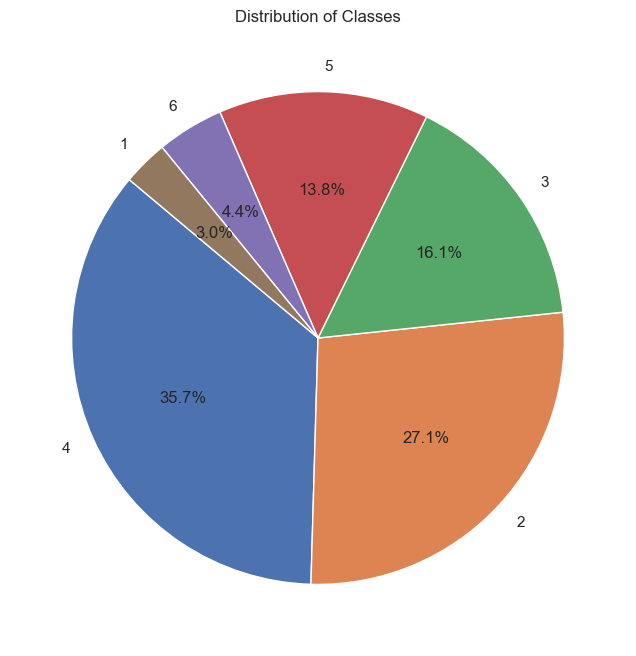

In [5]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

# Addestramento modelli
A seguito dell'esplorazione e dell'omogeneizzazione dei due dataset, si può procedere all'addestramento dei modelli. I modelli verranno addestrati sulle seguenti feature indipendenti:
- `year`: anno della misurazione
- `month`: mese dell’anno
- `dayofmonth`: giorno del mese
- `dayofweek`: giorno della settimana
- `dayofyear`: giorno dell’anno
- `weekofyear`: settimana dell’anno
- `quarter`: trimestre dell’anno
- `state`: stato di misurazione
- `pm_lag_1W`: PM2.5 ritardato di 1 settimana
- `pm_lag_1M`: PM2.5 ritardato di 1 mese
- `pm_lag_1Y`: PM2.5 ritardato di 1 anno
- `pm_lag_1D`: PM2.5 ritardato di 1 giorno
- `pm_lag_2D`: PM2.5 ritardato di 2 giorni
- `pm_lag_3D`: PM2.5 ritardato di 3 giorni
- `co_lag_1W`: CO ritardato di 1 settimana
- `co_lag_1M`: CO ritardato di 1 mese
- `co_lag_1Y`: CO ritardato di 1 anno
- `co_lag_1D`: CO ritardato di 1 giorno
- `co_lag_2D`: CO ritardato di 2 giorni
- `co_lag_3D`: CO ritardato di 1 anno
- `o3_lag_1W`: O3 ritardato di 1 settimana
- `o3_lag_1M`: O3 ritardato di 1 mese
- `o3_lag_1Y`: O3 ritardato di 1 anno
- `o3_lag_1D`: O3 ritardato di 1 giorno
- `o3_lag_2D`: O3 ritardato di 2 giorni
- `o3_lag_3D`: O3 ritardato di 3 giorni
- `so2_lag_1W`: SO2 ritardato di 1 settimana
- `so2_lag_1M`: SO2 ritardato di 1 mese
- `so2_lag_1Y`: SO2 ritardato di 1 anno
- `so2_lag_1D`: SO2 ritardato di 1 giorno
- `so2_lag_2D`: SO2 ritardato di 2 giorni
- `so2_lag_3D`: SO2 ritardato di 3 giorni
- `no2_lag_1W`: NO2 ritardato di 1 settimana
- `no2_lag_1M`: NO2 ritardato di 1 mese
- `no2_lag_1Y`: NO2 ritardato di 1 anno
- `no2_lag_1D`: NO2 ritardato di 1 giorno
- `no2_lag_2D`: NO2 ritardato di 2 giorni
- `no2_lag_3D`: NO2 ritardato di 3 giorni
- `pm10_lag_1W`: PM10 ritardato di 1 settimana
- `pm10_lag_1M`: PM10 ritardato di 1 mese
- `pm10_lag_1Y`: PM10 ritardato di 1 anno
- `pm10_lag_1D`: PM10 ritardato di 1 giorno
- `pm10_lag_2D`: PM10 ritardato di 2 giorni
- `pm10_lag_3D`: PM10 ritardato di 3 giorni


La variabile target per il nostro modello di addestramento sarà una variabile **discreta**, composta da 6 valori distinti. Questi valori rappresentano i diversi livelli di qualità dell'aria, come definiti dalla scala dell'**Environmental Protection Agency (EPA)** degli Stati Uniti per la concentrazione di PM2.5.

Possiamo mappare numericamente questi livelli alle seguenti classi, mantenendo l'ordine implicito di gravità:

* **1: "Good"** (Concentrazione di PM2.5: $0 - 9.0 \mu g/m^3$)
* **2: "Moderate"** (Concentrazione di PM2.5: $9.1 - 35.4 \mu g/m^3$)
* **3: "Unhealthy for Sensitive Groups"** (Concentrazione di PM2.5: $35.5 - 55.4 \mu g/m^3$)
* **4: "Unhealthy"** (Concentrazione di PM2.5: $55.5 - 125.4 \mu g/m^3$)
* **5: "Very Unhealthy"** (Concentrazione di PM2.5: $125.5 - 225.4 \mu g/m^3$)
* **6: "Hazardous"** (Concentrazione di PM2.5: $> 225.5 \mu g/m^3$)

Adottando questo schema, il problema si configura come un task di **classificazione multi-classe**. L'obiettivo del modello sarà prevedere a quale di questi 6 livelli di qualità dell'aria (o "categorie di rischio") appartiene una data osservazione, basandosi sulle caratteristiche di input fornite.

## Preparazione Dataset
Per garantire un confronto equo tra tutti i modelli, alcuni dei quali non supportano i valori mancanti generati dalle lag features, elimineremo tutte le righe che li contengono. Va però tenuto presente che così facendo perdiamo un anno di dati storici. Modelli come XGBoost di scikit-learn sono in grado di gestire internamente i missing value e potrebbero beneficiarne; tuttavia, per mantenere omogenee le condizioni di allenamento, applichiamo il drop completo dei NaN.

In [6]:
target = 'Class'
lag_features = ['pm_lag_1Y', 'pm_lag_1M', 'pm_lag_1W','co_lag_1Y',  'co_lag_1M', 'co_lag_1W','o3_lag_1Y', 'o3_lag_1M', 'o3_lag_1W','pm10_lag_1Y','so2_lag_1Y','no2_lag_1Y','pm10_lag_1M','so2_lag_1M','no2_lag_1M','pm10_lag_1W','so2_lag_1W','no2_lag_1W','pm_lag_1D','co_lag_1D','o3_lag_1D','pm10_lag_1D','so2_lag_1D','no2_lag_1D','pm_lag_2D','co_lag_2D','o3_lag_2D','pm10_lag_2D','so2_lag_2D','no2_lag_2D','pm_lag_3D','co_lag_3D','o3_lag_3D','pm10_lag_3D','so2_lag_3D','no2_lag_3D']
date_features = ['dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year', 'state']
predictors = date_features + lag_features

In [7]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    dataframe = dataframe.copy()

    if replace_na and method == 'zeros':
      dataframe = dataframe.fillna(0)
    elif replace_na and method == 'drop':
      dataframe = dataframe.dropna(how='any')

    train_set, test_set = np.split(dataframe, [int(len(dataframe) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [8]:
X_train, X_test, y_train, y_test = create_train_test_sets(
    df,
    split=0.8,
    replace_na=True,
    method='drop'
)

# Resetta gli indici dei risultati eliminando l’indice precedente,
# in modo da partire da zero ed avere indici continui
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

C:\Users\jacop\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10515 entries, 0 to 10514
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   dayofmonth   10515 non-null  int64   
 1   dayofweek    10515 non-null  int64   
 2   dayofyear    10515 non-null  int64   
 3   weekofyear   10515 non-null  int64   
 4   month        10515 non-null  int64   
 5   quarter      10515 non-null  int64   
 6   year         10515 non-null  int64   
 7   state        10515 non-null  category
 8   pm_lag_1Y    10515 non-null  float64 
 9   pm_lag_1M    10515 non-null  float64 
 10  pm_lag_1W    10515 non-null  float64 
 11  co_lag_1Y    10515 non-null  float64 
 12  co_lag_1M    10515 non-null  float64 
 13  co_lag_1W    10515 non-null  float64 
 14  o3_lag_1Y    10515 non-null  float64 
 15  o3_lag_1M    10515 non-null  float64 
 16  o3_lag_1W    10515 non-null  float64 
 17  pm10_lag_1Y  10515 non-null  float64 
 18  so2_lag_1Y   10515 non-nul

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   dayofmonth   2629 non-null   int64   
 1   dayofweek    2629 non-null   int64   
 2   dayofyear    2629 non-null   int64   
 3   weekofyear   2629 non-null   int64   
 4   month        2629 non-null   int64   
 5   quarter      2629 non-null   int64   
 6   year         2629 non-null   int64   
 7   state        2629 non-null   category
 8   pm_lag_1Y    2629 non-null   float64 
 9   pm_lag_1M    2629 non-null   float64 
 10  pm_lag_1W    2629 non-null   float64 
 11  co_lag_1Y    2629 non-null   float64 
 12  co_lag_1M    2629 non-null   float64 
 13  co_lag_1W    2629 non-null   float64 
 14  o3_lag_1Y    2629 non-null   float64 
 15  o3_lag_1M    2629 non-null   float64 
 16  o3_lag_1W    2629 non-null   float64 
 17  pm10_lag_1Y  2629 non-null   float64 
 18  so2_lag_1Y   2629 non-null  

In [11]:
print(y_train.value_counts())

Class
4    3762
2    2991
3    1696
5    1315
6     390
1     361
Name: count, dtype: int64


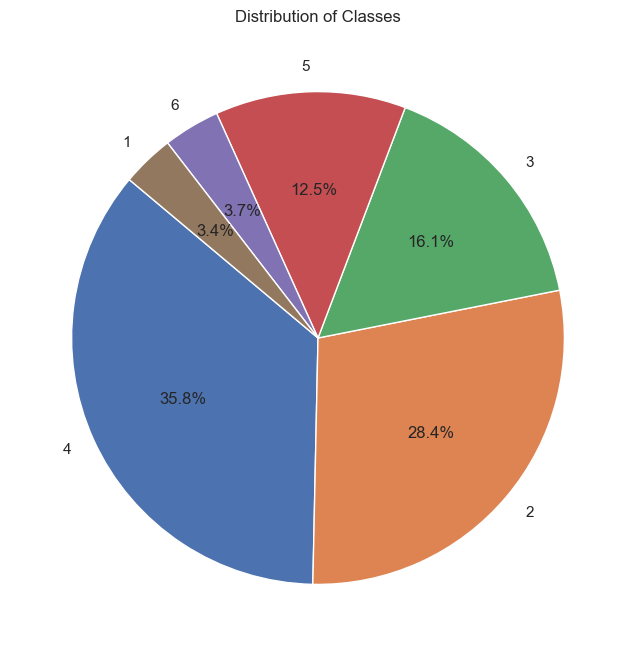

In [12]:
plt.figure(figsize=(8, 8))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [13]:
print(y_test.value_counts())

Class
2    818
4    809
5    406
3    381
6    143
1     72
Name: count, dtype: int64


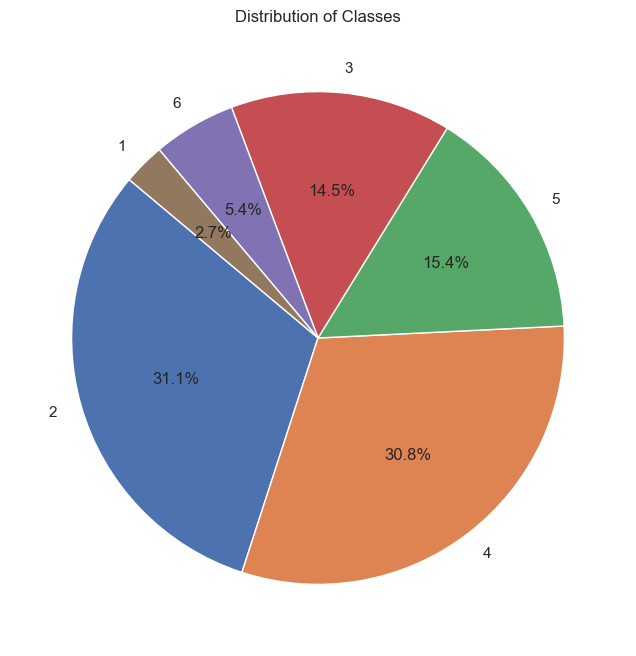

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

Nel dataset ci sono sia feature numeriche che categoriche. <br>
Per le numeriche è necessario applicare una normalizzazione dei dati, i quali avrebbero altrimenti valori su scale molto diverse che renderebbero più difficile la convergenza del modello. <br>
Per poter utilizzare le variabili categoriche nell'addestramento di un modello di regressione si usa un OneHotEncoder, creando nuove colonne binarie per ciascuno dei valori ammissibili dalla variabile categorica.

In [15]:
categorical_features = X_train.select_dtypes(include=["category"]).columns.tolist()
numerical_features   = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    # Standardizza tutte le colonne numeriche
    ("numeric",    StandardScaler(),    numerical_features),
    # One‑hot encoding di 'state', ignorando nuovi stati in predict
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
])

Inizializzazione della lista per raccogliere le metriche dopo ogni training

In [16]:
all_scores = []

## Valutazione delle Prestazioni dei Modelli

Dopo l’allenamento di ciascun modello di Machine Learning e Deep Learning, utilizziamo le funzioni `get_estimator_scores` e `get_torch_estimator_scores` per calcolare diverse metriche di valutazione, includendo per le principali anche gli **Intervalli di Confidenza al 95%** (CI95%) stimati tramite bootstrap resampling.

Queste metriche sono state scelte specificamente per valutare l'efficacia dei modelli in problemi di **classificazione multi-classe, con particolare attenzione alle classi sbilanciate**.

Le metriche calcolate sono:

1.  **Accuracy Score**
    Misura la percentuale di istanze classificate correttamente dal modello. Sebbene sia una metrica intuitiva, può essere fuorviante in presenza di classi sbilanciate, poiché un modello che classifica correttamente solo la classe maggioritaria può comunque mostrare un'alta accuratezza.
    *(Più alto è, meglio è.)*

2.  **F1-Score (Weighted)**
    L'F1-Score è la media armonica della Precisione e del Recall. La versione "weighted" calcola la media di F1-Score per ciascuna classe, pesandola in base al numero di istanze di quella classe nel dataset. Questa metrica è particolarmente utile per dataset con classi sbilanciate, in quanto fornisce una visione più bilanciata delle prestazioni del modello su tutte le classi, evitando di essere dominata dalla classe maggioritaria.
    *(Più alto è, meglio è.)*

3.  **F1-Score (Macro)**
    La versione "macro" dell'F1-Score calcola la media non pesata di F1-Score per ciascuna classe. Questo significa che ogni classe contribuisce in modo uguale alla metrica finale, indipendentemente dal suo numero di campioni. È utile quando tutte le classi, comprese quelle minoritarie, hanno la stessa importanza.
    *(Più alto è, meglio è.)*

4.  **Matrice di Confusione**
    Una tabella che riassume le prestazioni di un algoritmo di classificazione. Mostra il numero di previsioni corrette e sbagliate per ciascuna classe, indicando dove il modello sta confondendo le diverse categorie. È fondamentale per comprendere gli errori specifici del modello.

5.  **Classification Report**
    Fornisce un riepilogo dettagliato delle metriche di Precisione, Recall e F1-Score per ciascuna classe, oltre a metriche aggregate (macro avg, weighted avg). È uno strumento essenziale per una valutazione approfondita delle prestazioni per classe.

6.  **AUC-ROC (Area Under the Receiver Operating Characteristic Curve) - One-vs-Rest Weighted**
    L'AUC-ROC misura la capacità del modello di distinguere tra le classi. Per problemi multi-classe, si calcola spesso in modalità "one-vs-rest", trattando ogni classe come "positiva" e tutte le altre come "negative". La versione "weighted" ne calcola la media pesata per la frequenza delle classi, rendendola più robusta per dataset sbilanciati. Un valore più vicino a 1 indica una maggiore capacità discriminatoria.
    *(Più alto è, meglio è.)*

7.  **AUC-PR (Area Under the Precision-Recall Curve) - One-vs-Rest Weighted**
    L'AUC-PR è particolarmente utile per dataset con classi sbilanciate e quando la classe positiva (minoritaria) è di maggiore interesse. Misura l'area sotto la curva Precision-Recall, offrendo una valutazione più accurata della capacità del modello di identificare correttamente le istanze positive rispetto all'AUC-ROC, che può essere ottimistica in presenza di un grande numero di veri negativi. Per multi-classe, viene calcolata in modalità "one-vs-rest" e mediata pesando per la frequenza delle classi.
    *(Più alto è, meglio è.)*

In [17]:
def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_estimator_scores(model_name, model, X_test, y_test, X_train, y_train, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} ---")

    # Previsioni (etichette hard) per test e train
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Se il modello supporta predict_proba (per AUC)
    y_proba_test = None
    if hasattr(model, 'predict_proba'):
        y_proba_test = model.predict_proba(X_test) # Probabilità per ogni classe

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train, y_pred_train)
    f1_weighted_tr = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train, y_pred_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test, y_pred_test)
    f1_weighted_te = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI per F1-weighted (sostituisce MSE/MAE/MAPE CI)
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test, y_pred_test, average='macro', zero_division=0
    )

    # Matrice di Confusione e Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred_test))

    # Raccolta dei punteggi
    # Nota: R2, MSE, MAE, MAPE, Max Error sono stati rimossi.
    # Li abbiamo sostituiti con metriche di classificazione.
    scores_row = [
        model_name,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC se possibile (necessita probabilità)
    if y_proba_test is not None:
        try:
            num_classes = len(np.unique(y_test))
            auc_roc_ovr = roc_auc_score(y_test, y_proba_test, multi_class='ovr', average='weighted')
            auc_pr_ovr = average_precision_score(pd.get_dummies(y_test), y_proba_test, average='weighted')

            # Bootstrap per AUC-ROC e AUC-PR
            auc_roc_low, auc_roc_high = bootstrap_ci(
                lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
                y_test, y_proba_test
            )
            auc_pr_low, auc_pr_high = bootstrap_ci(
                lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
                y_test, y_proba_test
            )

            scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
            print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
            print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

        except ValueError as e:
            print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
            scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    else:
        print("Modello non supporta predict_proba. AUC/PR non calcolabili.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC

    all_scores_list.append(scores_row)


def predict_torch(model, X_tensor, device):
    model.eval()
    with torch.no_grad():
        out = model(X_tensor.to(device))
    return out # Restituisce logit/probabilità, non etichette hard qui


def get_torch_estimator_scores(model_name, model,
                               X_train_tensor, y_train_tensor,
                               X_test_tensor, y_test_tensor,
                               device, all_scores_list):
    print(f"\n--- Valutazione Prestazioni per {model_name} (PyTorch) ---")

    # Ottieni output (logits/probabilità) dal modello
    y_pred_proba_train = predict_torch(model, X_train_tensor, device)
    y_pred_proba_test = predict_torch(model, X_test_tensor, device)

    # Converti le etichette vere (tensori) in numpy array per Scikit-learn
    y_train_np = y_train_tensor.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

    # Se il modello emette logit, converti in probabilità e poi in etichette
    y_pred_labels_train = torch.argmax(softmax(y_pred_proba_train, dim=1), dim=1).detach().cpu().numpy()
    y_pred_labels_test = torch.argmax(softmax(y_pred_proba_test, dim=1), dim=1).detach().cpu().numpy()

    # --- Metriche su Training Set ---
    accuracy_tr = accuracy_score(y_train_np, y_pred_labels_train)
    f1_weighted_tr = f1_score(y_train_np, y_pred_labels_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_train_np, y_pred_labels_train, average='macro', zero_division=0)

    # --- Metriche su Test Set ---
    accuracy_te = accuracy_score(y_test_np, y_pred_labels_test)
    f1_weighted_te = f1_score(y_test_np, y_pred_labels_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_test_np, y_pred_labels_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_test_np, y_pred_labels_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_np, y_pred_labels_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test_np, y_pred_labels_test))

    scores_row = [
        model_name,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC (necessita probabilità)
    try:
        auc_roc_ovr = roc_auc_score(y_test_np, softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                    multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_test_np), softmax(y_pred_proba_test, dim=1).detach().cpu().numpy(),
                                            average='weighted')

        # Bootstrap per AUC-ROC e AUC-PR
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, softmax(torch.tensor(yp), dim=1).numpy(), multi_class='ovr', average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), softmax(torch.tensor(yp), dim=1).numpy(), average='weighted'),
            y_test_np, y_pred_proba_test.detach().cpu().numpy()
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}. Probabilmente mancano classi o y_proba non è adatto.")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN per le colonne AUC
    except Exception as e:
        print(f"Errore generico nel calcolo di AUC/PR per PyTorch: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]) # Aggiungi NaN

    all_scores_list.append(scores_row)

## Cross Validation TimeSeriesSplit
La validazione viene eseguita con `TimeSeriesSplit`, una tecnica di cross-validation adatta alle Serie Temporali, che preserva l’ordine cronologico dividendo il dataset in fold sequenziali.

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

Nel blocco seguente viene visualizzata la suddivisione del dataset nei 5 fold della Time Series Cross-Validation.  
Questa rappresentazione è utile per verificare che la sequenza temporale sia rispettata nella divisione dei dati tra training e validation set.


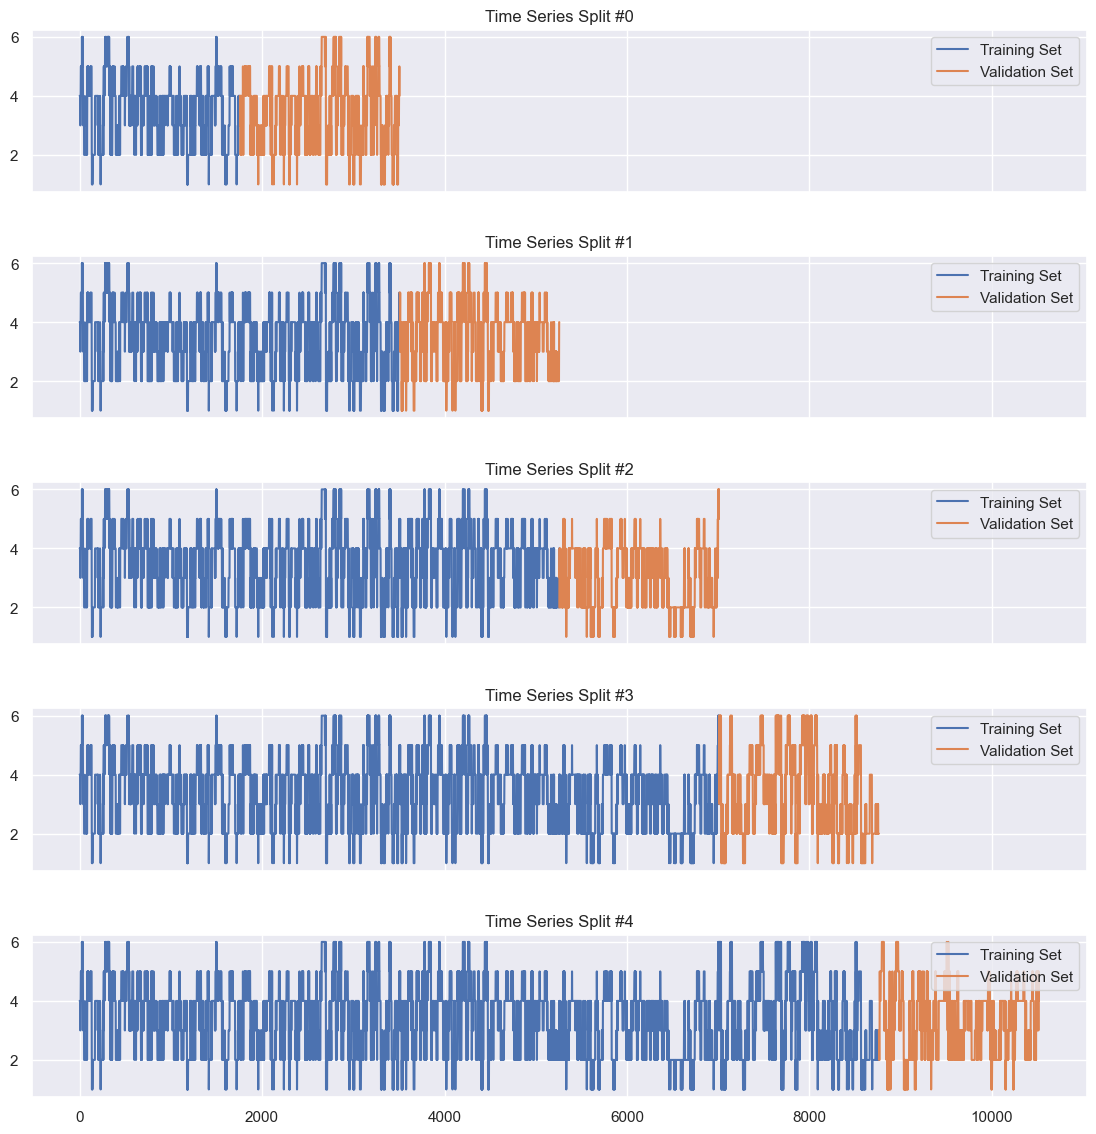

In [19]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)

for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)): # Usa y_train qui
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)

plt.show()

## Random forest
Il modello Random Forest è un ensemble di alberi decisionali che migliora la stabilità e la capacità predittiva rispetto a un singolo albero. Ogni albero viene addestrato su un sottoinsieme casuale del dataset (bagging) e valuta solo una parte delle feature, rendendo l’insieme più robusto a overfitting e variazioni nei dati.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `max_samples=0.2`: ogni albero è addestrato su un campione casuale del 20% dei dati originali (con ripetizione);
- `max_features='sqrt'`: ogni nodo dell’albero valuta solo un sottoinsieme di feature pari alla radice quadrata del numero totale di feature disponibili;
- `n_estimators=200`: il modello è composto da 200 alberi decisionali;
- `max_depth=None`: gli alberi possono crescere fino a foglie pure, senza una profondità massima prefissata;
- `n_jobs=-1`: sfrutta tutti i core CPU disponibili per il training parallelo;
- `random_state=RANDOM_STATE`: Per la riproducibilità.
- `class_weight='balanced'`: attribuisce un peso inversamente proporzionale alla frequenza delle classi per gestire eventuali sbilanciamenti nel dataset.

In [20]:
model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(max_samples=0.2, max_features="sqrt",
                                    n_estimators=200, max_depth=None,
                                    n_jobs=N_JOBS, random_state=RANDOM_STATE,
                                    class_weight='balanced'))
])

In [21]:
%time model.fit(X_train, y_train)
print()

C:\Users\jacop\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jacop\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jacop\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jacop\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\jacop\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProce

CPU times: total: 15.7 s
Wall time: 2.1 s



Possiamo ricavare le 10 feature più importanti per la Random Forest, ovvero le variabili che sono state più utilizzate nella creazione degli alberi decisionali.

In [22]:
pd.Series(model.named_steps["tree"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D      0.062132
numeric__pm10_lag_1D    0.050805
numeric__no2_lag_1D     0.039590
numeric__co_lag_1D      0.038987
numeric__o3_lag_1D      0.029832
numeric__so2_lag_1D     0.029648
numeric__dayofyear      0.029089
numeric__dayofmonth     0.026278
numeric__co_lag_2D      0.023914
numeric__pm_lag_2D      0.023913
dtype: float64

### Hyperparameter Tuning per Random Forest

Eseguiamo una ricerca randomizzata (`RandomizedSearchCV`) per ottimizzare un insieme ampio di iperparametri fondamentali del modello Random Forest:

- `n_estimators`: numero di alberi nella foresta;
- `max_samples`: frazione massima di campioni usata per addestrare ogni singolo albero;
- `max_depth`: profondità massima degli alberi;
- `min_samples_leaf`: numero minimo di campioni richiesti per una foglia;
- `max_features`: numero massimo di feature da considerare per ogni split.

In questa fase di tuning, la pipeline include anche la tecnica di oversampling **SMOTE**, applicata correttamente all'interno di ogni fold di **Time Series Cross-Validation** per evitare il data leakage.

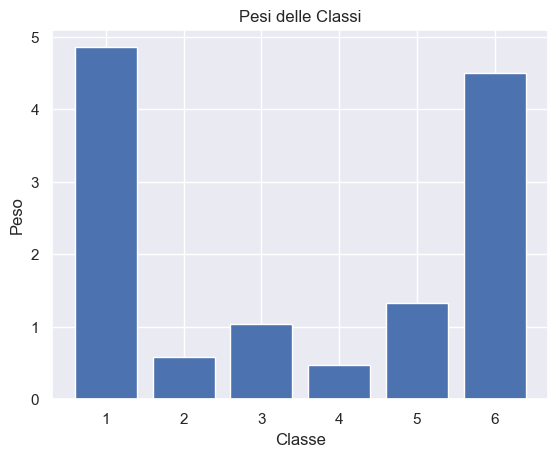

In [23]:
class_labels = np.unique(y_train)
initial_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
initial_class_weight_dict = dict(zip(class_labels, initial_weights))
plt.bar(class_labels, initial_weights)
plt.title('Pesi delle Classi')
plt.xlabel('Classe')
plt.ylabel('Peso')
plt.show()

In [24]:
grid = {
    'tree__n_estimators': [150, 200, 250],
    'tree__max_samples': [0.5, 0.8, 1.0],
    'tree__max_depth': [5, 10, 20],
    'tree__min_samples_leaf': [2, 5, 10],
    'tree__max_features': ['sqrt', 'log2']
}
model_ht = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("tree", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])
gs = RandomizedSearchCV(model_ht, grid, n_iter=36, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=2)

**Scelta del numero di iterazioni per RandomizedSearchCV con questo grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 162
$$

Supponiamo di voler avere una probabilità \( P = 0{,}90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 162.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{162}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{152}{162}\right)} = \frac{-2.3026}{\ln(152/162)} \approx \frac{2.3026}{0.0637} \approx 36.2
$$

Quindi, con **36 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 162 combinazioni.


**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [25]:
%time gs.fit(X_train, y_train)
print()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 26.8 s
Wall time: 4min 39s



In [26]:
get_estimator_scores("random_forest", gs.best_estimator_, X_test, y_test, X_train, y_train, all_scores)


--- Valutazione Prestazioni per random_forest ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.08      0.19      0.11        72
           2       0.55      0.55      0.55       818
           3       0.14      0.09      0.11       381
           4       0.48      0.32      0.38       809
           5       0.35      0.47      0.40       406
           6       0.23      0.50      0.32       143

    accuracy                           0.39      2629
   macro avg       0.30      0.35      0.31      2629
weighted avg       0.41      0.39      0.39      2629


Confusion Matrix (Test Set):
[[ 14  50   3   5   0   0]
 [ 81 452  81 108  77  19]
 [ 36 124  33  83  95  10]
 [ 39 192  88 257 126 107]
 [  1   9  30  78 191  97]
 [ 11   0   6   2  53  71]]
AUC-ROC (OVR, Weighted): 0.706
AUC-PR (OVR, Weighted): 0.425


Il grafico illustra l’andamento dello score medio di validazione in funzione del numero di alberi, suddiviso per profondità massima degli alberi. Questa analisi aiuta a bilanciare la complessità degli alberi e la quantità di alberi per ottenere le migliori performance.

In [27]:
results = pd.DataFrame(gs.cv_results_)[[
    "param_tree__n_estimators",
    "param_tree__max_samples",
    "param_tree__max_depth",
    "mean_test_score"
]]

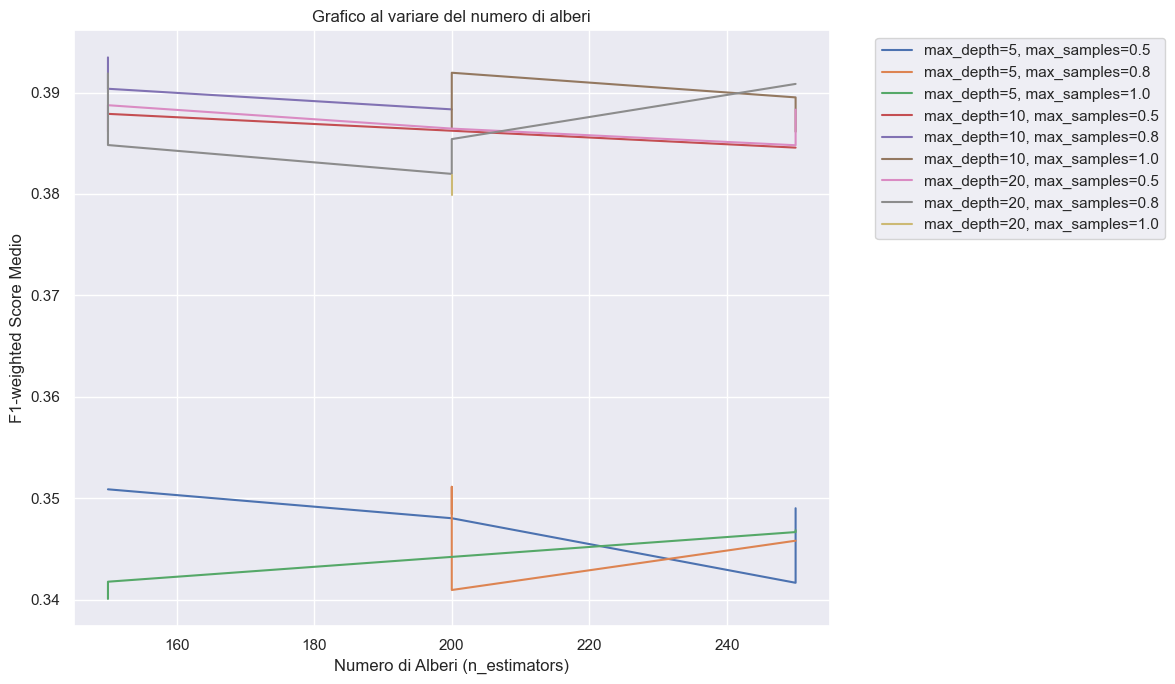

In [28]:
results["param_tree__n_estimators"] = results["param_tree__n_estimators"].astype(int)
results["param_tree__max_depth"] = results["param_tree__max_depth"].astype(int)
results["param_tree__max_samples"] = results["param_tree__max_samples"].astype(float)

plt.figure(figsize=(12, 7))

for depth in sorted(results["param_tree__max_depth"].unique()):
    for sample in sorted(results["param_tree__max_samples"].unique()):
        subset = results[
            (results["param_tree__max_depth"] == depth) &
            (results["param_tree__max_samples"] == sample)
        ].sort_values("param_tree__n_estimators")

        label = f"max_depth={depth}, max_samples={sample}"
        plt.plot(
            subset["param_tree__n_estimators"],
            subset["mean_test_score"],
            label=label
        )

plt.title("Grafico al variare del numero di alberi")
plt.xlabel("Numero di Alberi (n_estimators)")
plt.ylabel("F1-weighted Score Medio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost

XGBoost è un'implementazione ottimizzata di algoritmi di gradient boosting. A differenza del Random Forest che costruisce alberi indipendenti e poi ne aggrega i risultati, XGBoost costruisce alberi in sequenza, con ogni nuovo albero che corregge gli errori degli alberi precedenti.

In questa configurazione iniziale, definiamo una pipeline che include anche una tecnica di **oversampling (SMOTE)** per bilanciare le classi nel dataset di addestramento.

La pipeline è così configurata:
- `sampler`: **SMOTE (Synthetic Minority Over-sampling Technique)**, che genera nuovi campioni sintetici per le classi minoritarie, rendendo il dataset più bilanciato per l'addestramento. `random_state` garantisce la riproducibilità.
- `xgb`: il classificatore XGBoost con i seguenti iperparametri iniziali:
    - `objective='multi:softprob'`: Specifica la funzione obiettivo di classificazione multi-classe, dove l'output è un array di probabilità per ogni classe. Questo è necessario per le metriche AUC.
    - `num_class`: numero totale di classi.
    - `n_estimators=200`: numero di alberi di boosting da costruire.
    - `learning_rate=0.1`: La dimensione del passo di ridimensionamento del contributo di ogni albero.
    - `use_label_encoder=False`: parametro deprecato e quindi va disabilitato per evitare warning.
    - `eval_metric='mlogloss'`: metrica di valutazione da usare durante l'addestramento.
    - `n_jobs=N_JOBS`: Sfrutta tutti i core CPU disponibili per il training parallelo.
    - `random_state=RANDOM_STATE`: Per la riproducibilità.

**Nota Importante:** Per XGBoost con multi-classe, le etichette della classe devono essere convertite in indici che partono da 0.

In [29]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1
num_classes = len(np.unique(y_train_xgb))

model = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              n_estimators=200,
                              learning_rate=0.1,
                              use_label_encoder=False, # Deprecato, imposto a False
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              random_state=RANDOM_STATE))
])

In [30]:
%time model.fit(X_train, y_train_xgb)
print()

C:\Users\jacop\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CPU times: total: 54.8 s
Wall time: 6.98 s



Possiamo ricavare le 10 feature più importanti per l'XGBoost Classifier, ovvero le variabili che sono state più utilizzate nella creazione degli alberi di boosting.

In [31]:
pd.Series(model.named_steps["xgb"].feature_importances_, preprocessor.get_feature_names_out(X_train.columns)).sort_values(ascending=False).head(10)

numeric__pm_lag_1D                 0.084122
numeric__quarter                   0.046749
categorical__state_Tiantan         0.034467
categorical__state_Aotizhongxin    0.034210
categorical__state_Dingling        0.034030
numeric__month                     0.028202
numeric__no2_lag_1D                0.027801
categorical__state_Guanyuan        0.026454
numeric__weekofyear                0.023818
numeric__co_lag_2D                 0.023219
dtype: float32

### Hyperparameter Tuning per XGBoost
Eseguiamo una ricerca esaustiva (GridSearchCV) per ottimizzare iperparametri fondamentali del modello XGBoost, combinandoli con la tecnica di resampling SMOTE. Ottimizzeremo:
- `n_estimators`: Numero di alberi di boosting.
- `learning_rate`: La dimensione del passo che riduce il contributo di ogni nuovo albero.
- `max_depth`: La profondità massima di un albero.

In questa fase di tuning, la pipeline includerà anche la tecnica di oversampling SMOTE, che verrà applicata in modo appropriato a ogni fold di cross-validation per garantire che il modello sia addestrato su un dataset bilanciato senza data leakage.


In [32]:
grid = {
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.1, 0.2, 0.3],
    "xgb__n_estimators": [100, 200, 300],
}
model_ht = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", SMOTE(random_state=RANDOM_STATE)),
    ("xgb", xgb.XGBClassifier(objective='multi:softprob',
                              num_class=num_classes,
                              use_label_encoder=False, # Deprecato
                              eval_metric='mlogloss',
                              n_jobs=N_JOBS,
                              random_state=RANDOM_STATE))
])
gs = GridSearchCV(model_ht, grid, cv=tscv, scoring='f1_weighted', n_jobs=N_JOBS, verbose=2)

In [33]:
%time gs.fit(X_train, y_train_xgb)
print()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\jacop\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CPU times: total: 16.6 s
Wall time: 3min 46s



In [34]:
get_estimator_scores("xgboost", gs.best_estimator_, X_test, y_test_xgb, X_train, y_train_xgb, all_scores)


--- Valutazione Prestazioni per xgboost ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.07      0.28      0.11        72
           1       0.58      0.45      0.51       818
           2       0.12      0.07      0.09       381
           3       0.43      0.32      0.37       809
           4       0.31      0.41      0.35       406
           5       0.21      0.52      0.30       143

    accuracy                           0.35      2629
   macro avg       0.29      0.34      0.29      2629
weighted avg       0.39      0.35      0.36      2629


Confusion Matrix (Test Set):
[[ 20  41   2   9   0   0]
 [129 366  43 163  97  20]
 [ 64  84  27  90  84  32]
 [ 53 134  96 261 147 118]
 [ 13   3  44  75 165 106]
 [  1   2   8  11  46  75]]
AUC-ROC (OVR, Weighted): 0.688
AUC-PR (OVR, Weighted): 0.394


Il grafico illustra l’andamento dello score medio di validazione in funzione del numero di alberi, suddiviso per learning rate e profondità massima, tenendo conto dell'effetto del resampling.

In [35]:
results_xgb = pd.DataFrame(gs.cv_results_)[[
    "param_xgb__n_estimators",
    "param_xgb__learning_rate",
    "param_xgb__max_depth",
    "mean_test_score"
]]

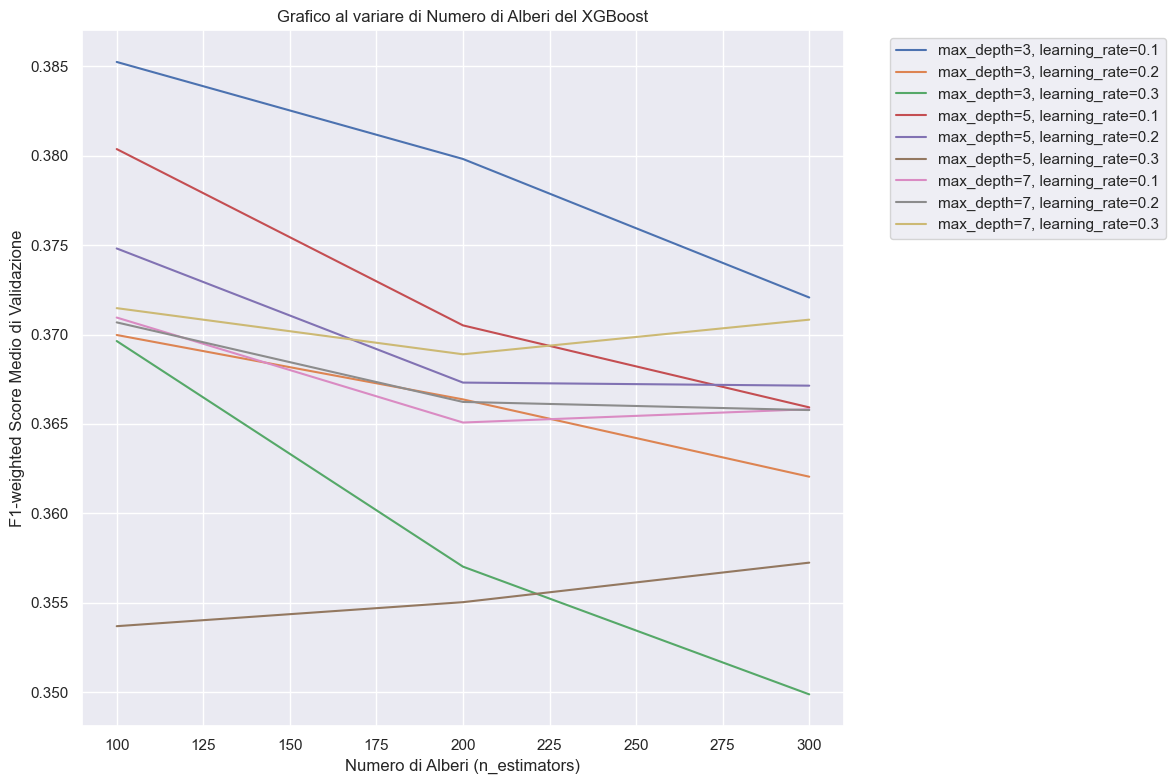

In [36]:
plt.figure(figsize=(12, 8))
for depth in sorted(results_xgb["param_xgb__max_depth"].unique()):
    for lr in sorted(results_xgb["param_xgb__learning_rate"].unique()):
        subset = results_xgb[(results_xgb["param_xgb__max_depth"] == depth) &
                             (results_xgb["param_xgb__learning_rate"] == lr)]
        subset = subset.sort_values("param_xgb__n_estimators")
        plt.plot(
            subset["param_xgb__n_estimators"],
            subset["mean_test_score"],
            label=f"max_depth={depth}, learning_rate={lr}"
        )

plt.xlabel('Numero di Alberi (n_estimators)')
plt.ylabel(f'F1-weighted Score Medio di Validazione')
plt.title(f"Grafico al variare di Numero di Alberi del XGBoost")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## MLP
Definiamo una rete neurale di tipo feed-forward composta da più layer completamente connessi. La classe MLP consente:

- Di personalizzare il numero e la dimensione dei layer nascosti tramite hidden_sizes;
- Di usare la funzione di attivazione ReLU per introdurre non-linearità;
- Di applicare dropout dopo ogni attivazione per mitigare l'overfitting;
- Di configurare il numero di neuroni nello strato di output (es. per classificazione multiclasse).

Il modello viene istanziato sul dispositivo disponibile, GPU se presente, altrimenti CPU.


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, dropout, num_classes):
        super().__init__()
        layers = []
        dim = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

Device utilizzato: cpu


### Implementazione dell’Early Stopping

La classe `EarlyStopper` implementa una logica di early stopping che interrompe anticipatamente l’addestramento se la performance sul validation set non migliora oltre una soglia (min_delta) per un numero consecutivo di epoche (patience).
Questo approccio aiuta a evitare l’overfitting e riduce i tempi di addestramento, salvando il modello con la miglior loss di validazione osservata.

In [38]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Funzioni per il training e la valutazione

- `train_epoch`: esegue una singola epoca di training. Calcola le previsioni, applica la loss function, esegue il backpropagation e aggiorna i pesi del modello. La loss viene aggregata e normalizzata sulla dimensione del dataset.

- `eval_loss`: calcola la loss media del modello sul validation set in modalità eval, disabilitando l’aggiornamento dei pesi. Questo è fondamentale per valutare le prestazioni in modo affidabile durante il training.

In [39]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        loss = criterion(model(Xb), yb.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    return total_loss / len(loader.dataset)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            total_loss += criterion(model(Xb), yb.long()).item() * Xb.size(0)
    return total_loss / len(loader.dataset)

### Random Search con Cross-Validation temporale e Early Stopping

La funzione `random_search` implementa una strategia di ottimizzazione degli iperparametri che:

- Estrae in modo casuale combinazioni di iperparametri dallo spazio definito (param_dist);
- Valuta ogni configurazione tramite Cross Validation TimeSeriesSplit per rispettare l’ordine temporale dei dati;
- Addestra un modello MLP per ciascun fold monitorando la loss di validazione;
- Applica early stopping durante l’allenamento per evitare overfitting;
- Calcola la media delle validation loss su tutti i fold per ogni configurazione.

La combinazione con la miglior media viene salvata come modello ottimale, insieme agli iperparametri migliori.

In [40]:
def random_search(model_builder, param_dist, dataset,
                  n_iter=10, cv_folds=5,
                  early_patience=5,
                  early_min_delta=1e-4,
                  class_weights=None):
    train_keys = ['lr', 'batch_size', 'max_epochs']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=cv_folds)

    print("Avvio Random Search con Time Series Cross Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=RANDOM_STATE)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(range(len(dataset)))):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            sub_train_dataset = Subset(dataset, train_idx)
            val_set = Subset(dataset, val_idx)

            # Calcola i pesi dei campioni per il training set del fold corrente
            # Basato sulle etichette originali (0-indexed) del sotto-dataset di training
            train_labels_fold = np.array([dataset.tensors[1][i].item() for i in train_idx])
            unique_labels, counts = np.unique(train_labels_fold, return_counts=True)
            # Pesi inversamente proporzionali alla frequenza
            # Gestisce il caso in cui una classe possa mancare in un fold
            sample_weights = np.zeros(len(train_labels_fold))
            for i, label in enumerate(unique_labels):
                if class_weights is not None and label in class_weights:
                    # Usa il peso globale calcolato prima
                    weight_for_label = class_weights[label]
                else:
                    # Fallback a un peso bilanciato locale se non specificato globalmente o classe mancante
                    weight_for_label = 1. / counts[np.where(unique_labels == label)[0][0]]
                sample_weights[train_labels_fold == label] = weight_for_label

            sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights), # Num samples è len(sub_train_dataset) per oversampling proporzionale
                replacement=True # Necessario per oversampling
            )
            # DataLoader con il sampler ponderato per il training
            train_loader = DataLoader(sub_train_dataset, batch_size=train_params['batch_size'], sampler=sampler)
            # Val loader rimane normale
            val_loader = DataLoader(val_set, batch_size=train_params['batch_size'], shuffle=False)

            model = model_builder(**model_params).to(device)
            optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(train_params['max_epochs']):
                train_loss = train_epoch(model, train_loader, optimizer, criterion)
                val_loss = eval_loss(model, val_loader, criterion)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_loss(model, val_loader, criterion)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            best_model = model_builder(**best_model_params).to(device)
            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Preparazione dati e spazio di ricerca iperparametri

In questa sezione:

- Applichiamo la trasformazione dei dati tramite il preprocessor già definito in precedenza;

- Convertiamo le etichette y_train e y_test in formato 0-indexed, come richiesto dalla CrossEntropyLoss di PyTorch;

- Creiamo un dataset PyTorch (TensorDataset) con input e target;

- Definiamo lo spazio di ricerca per gli iperparametri, tra cui:

 Architettura della rete (hidden_sizes);

 Dropout;

 Tasso di apprendimento (lr);

 Dimensione del batch;

 Numero massimo di epoche (max_epochs);

 Numero di classi.

Calcoliamo infine i pesi delle classi per bilanciare la loss in presenza di squilibri nella distribuzione delle etichette.

In [41]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

y_train_0_indexed = y_train.values - 1
y_test_0_indexed = y_test.values - 1

X_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_train_0_indexed, dtype=torch.long)

full_dataset = TensorDataset(X_tensor, y_tensor)

input_dim = X_tensor.shape[1]
num_classes = len(np.unique(y_train_0_indexed))

mlp_param_dist = {
    'input_dim': [input_dim],
    'hidden_sizes': [(32,32), (64,64), (128,)],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'max_epochs': [50, 100],
    'num_classes': [num_classes]
}

class_labels_0_indexed = np.unique(y_train_0_indexed)
class_weights_balanced = compute_class_weight(class_weight='balanced', classes=class_labels_0_indexed, y=y_train_0_indexed)
class_weights_dict = dict(zip(class_labels_0_indexed, class_weights_balanced))

### Avvio della ricerca e valutazione

- Eseguiamo la funzione random_search, fornendo:

 Il costruttore della rete MLP;

 Lo spazio degli iperparametri;

 Il dataset PyTorch e i pesi delle classi calcolati in precedenza;

- Al termine, il modello con la miglior media di validation loss viene selezionato e restituito;

In [42]:
best_model, model_params_mlp, train_params_mlp = random_search(
    lambda **p: MLP(**p), mlp_param_dist, full_dataset,
    class_weights=class_weights_dict # Passa i pesi delle classi
)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_0_indexed, dtype=torch.long).to(device)

Avvio Random Search con Time Series Cross Validation...
Testing parameter set 1/10
  Fold 1/5
    Epoch 0: train_loss = 1.616619, val_loss = 1.587117
    Early stopping at epoch 7, best_val_loss: 1.538393
  Fold 2/5
    Epoch 0: train_loss = 1.506155, val_loss = 1.628819
    Early stopping at epoch 7, best_val_loss: 1.505851
  Fold 3/5
    Epoch 0: train_loss = 1.453586, val_loss = 1.341845
    Early stopping at epoch 7, best_val_loss: 1.326967
  Fold 4/5
    Epoch 0: train_loss = 1.386384, val_loss = 1.674623
    Early stopping at epoch 5, best_val_loss: 1.674623
  Fold 5/5
    Epoch 0: train_loss = 1.392488, val_loss = 1.495942
    Early stopping at epoch 5, best_val_loss: 1.495942
  Mean validation loss: 1.847076
  New best validation loss: 1.847076
Testing parameter set 2/10
  Fold 1/5
    Epoch 0: train_loss = 1.780078, val_loss = 1.789296
    Epoch 10: train_loss = 1.717320, val_loss = 1.739734
    Epoch 20: train_loss = 1.672259, val_loss = 1.706693
    Epoch 30: train_loss = 1.

In [43]:
get_torch_estimator_scores("MLP", best_model,
                           X_tensor.to(device), y_tensor.to(device),
                           X_test_tensor, y_test_tensor,
                           device, all_scores)


--- Valutazione Prestazioni per MLP (PyTorch) ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.07      0.62      0.12        72
           1       0.53      0.34      0.42       818
           2       0.13      0.15      0.14       381
           3       0.41      0.04      0.07       809
           4       0.37      0.46      0.41       406
           5       0.21      0.57      0.31       143

    accuracy                           0.26      2629
   macro avg       0.28      0.36      0.24      2629
weighted avg       0.38      0.26      0.25      2629


Confusion Matrix (Test Set):
[[ 45  21   4   2   0   0]
 [305 280 117   5  77  34]
 [113  73  57  26  81  31]
 [175 142 218  29 123 122]
 [ 31  13  51   9 187 115]
 [ 14   1   6   0  41  81]]
AUC-ROC (OVR, Weighted): 0.687
AUC-PR (OVR, Weighted): 0.380


# Confronto Visivo delle Prestazioni dei Modelli

La funzione `plot_estimator_scores` consente di visualizzare in modo sintetico ed intuitivo le metriche di valutazione di tutti i modelli allenati.

Questa visualizzazione finale è utile per trarre conclusioni sulla bontà predittiva di ciascun modello e guidare la scelta del miglior approccio da adottare.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_estimator_scores(scores):
    # Prepariamo i dati per il plot di Accuracy (Train vs Test)
    melted_accuracy = (
        scores[['Model', 'Accuracy_Train', 'Accuracy_Test']]
        .rename(columns={'Accuracy_Train': 'Train', 'Accuracy_Test': 'Test'})
        .melt(id_vars='Model', var_name='Set', value_name='Score')
    )

    model_order = scores['Model'].tolist()

    fig, axs = plt.subplots(2, 3, figsize=(18, 10)) # Aumenta la dimensione per ancora più leggibilità
    fig.tight_layout(pad=4.0) # Aumenta il padding tra i subplot

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy')
    sns.barplot(data=melted_accuracy, x='Score', y='Model', hue='Set', ax=axs[0, 0], order=model_order)
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].legend(loc='lower right', title='Set')
    axs[0, 0].set_xlim(0, 1)

    # --- Funzione helper per disegnare barh con CI in modo consistente ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order):
        ax.set_title(title)
        # Assicurati che i dati siano ordinati per il plot coerente
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            # Gestisci i valori NaN per i CI
            val = row[metric_col]
            if pd.isna(val):
                continue # Salta il modello se il valore della metrica è NaN

            err_low = [val - row[ci_low_col]] if not pd.isna(row[ci_low_col]) else [0]
            err_high = [row[ci_high_col] - val] if not pd.isna(row[ci_high_col]) else [0]

            ax.barh(
                row['Model'], val,
                xerr=[err_low, err_high],
                capsize=5,
                color=sns.color_palette("viridis")[i % len(sns.color_palette("viridis"))] # Colore coerente
            )
        ax.set_xlabel(title.split(' ')[0]) # Estrae il nome della metrica dal titolo
        ax.invert_yaxis() # Per avere lo stesso ordine dei modelli sull'asse y
        ax.set_xlim(0, 1) # Imposta i limiti per le metriche [0, 1]

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order)


    # --- Plot 6: Rimuove l'asse vuoto ---
    axs[1, 2].axis('off')

    plt.show()

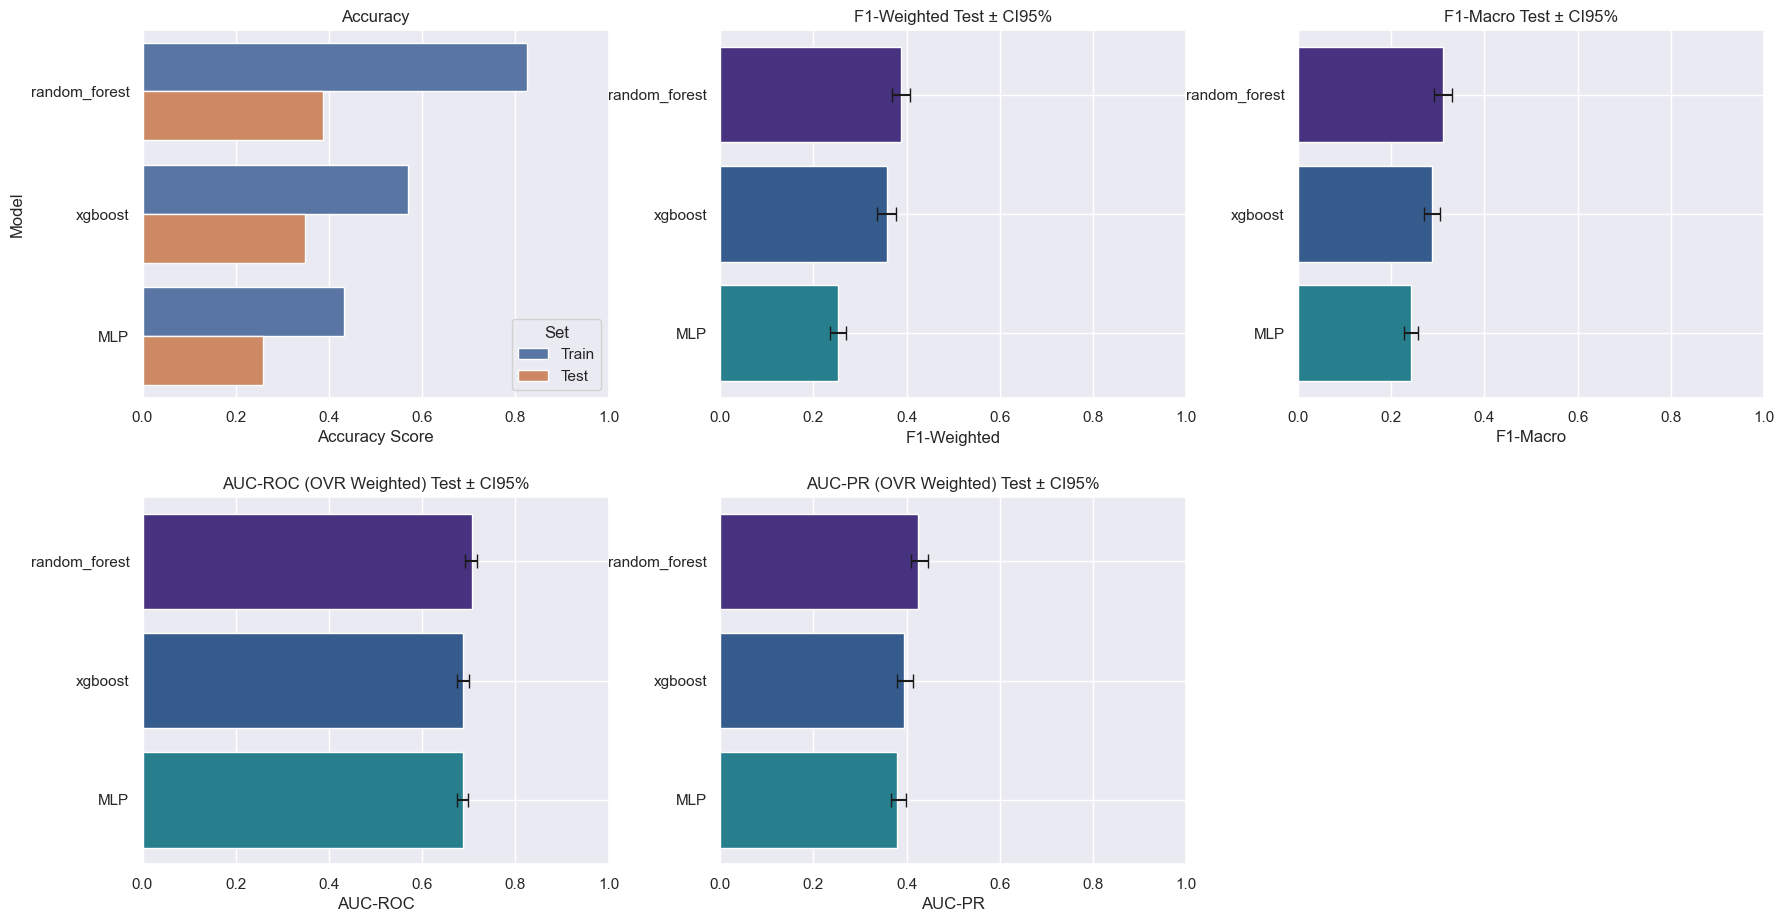

In [45]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model',
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [46]:
# 1) Scegliamo le metriche da includere nel ranking
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Costruzione DataFrame dei rank
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calcolo dei rank per ogni singola metrica
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# 3) Calcolo punteggio complessivo: somma dei rank
ranks['total_rank'] = ranks.sum(axis=1)

# 4) Selezione del miglior modello
best_model = ranks['total_rank'].idxmin()
best_score = ranks['total_rank'].min()

# Output dei risultati
print("Ranking modelli:")
display(ranks.sort_values('total_rank'))

print(f"\nMiglior modello: {best_model} (punteggio complessivo = {best_score:.2f})")

Ranking modelli:


,Accuracy_Test_rank,F1_Weighted_Test_rank,F1_Macro_Test_rank,AUC_ROC_OVR_Weighted_rank,AUC_PR_OVR_Weighted_rank,total_rank
Model,,,,,,
random_forest,1.0,1.0,1.0,1.0,1.0,5.0
xgboost,2.0,2.0,2.0,2.0,2.0,10.0
MLP,3.0,3.0,3.0,3.0,3.0,15.0



Miglior modello: random_forest (punteggio complessivo = 5.00)


In [47]:
print(f"\nMiglior modello: {best_model} (punteggio complessivo = {best_score})")


Miglior modello: random_forest (punteggio complessivo = 5.0)
